# Import libraries

In [ ]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Pull all data into df

In [ ]:
soda = "https://data.cityofnewyork.us/resource/43nn-pn8j.json"

limit = 50000 # max limit of soda api
offset = 0

all_data = []

while True:
    parameters = {
        "$limit": limit,
        "$offset": offset,
    }

    response = requests.get(soda, params=parameters)

    if response.status_code == 200:
        data = response.json()
        if not data:
            break
        # append data from this iteration and increase offset
        all_data.extend(data)
        offset += limit
    else:
        print("Error:", response.status_code, response.text)
        break

df = pd.DataFrame(all_data)
display(df)

,camis,dba,boro,building,street,zipcode,phone,inspection_date,critical_flag,record_date,...,bbl,nta,cuisine_description,action,score,inspection_type,violation_code,violation_description,grade,grade_date
0,50106271,SOUR MOUSE,Manhattan,110,DELANCEY STREET,10002,6462567220,1900-01-01T00:00:00.000,Not Applicable,2023-12-01T06:00:10.000,...,1004100064,MN27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50117820,MODELLO BAR - BARCLAYS CENTER,Brooklyn,620,ATLANTIC AVENUE,11217,9174174384,1900-01-01T00:00:00.000,Not Applicable,2023-12-01T06:00:10.000,...,3011180001,BK37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50141790,NaN,Manhattan,30,EAST 20 STREET,10003,9176670036,1900-01-01T00:00:00.000,Not Applicable,2023-12-01T06:00:10.000,...,1008480053,MN13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50134862,FINE AND RAW CHOCOLATE,Brooklyn,70,SCOTT AVENUE,11237,6462440734,1900-01-01T00:00:00.000,Not Applicable,2023-12-01T06:00:10.000,...,3029900001,BK90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50127238,THE DELUXE PARTY KTV,Queens,3420,LINDEN PL,11354,9172957843,1900-01-01T00:00:00.000,Not Applicable,2023-12-01T06:00:10.000,...,4049500018,QN22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209784,50129459,BLUEBERRY,Brooklyn,1849,CONEY ISLAND AVENUE,11230,3473719836,2023-08-03T00:00:00.000,Critical,2023-12-01T06:00:08.000,...,3067580090,BK43,Bakery Products/Desserts,Violations were cited in the following area(s).,50,Cycle Inspection / Initial Inspection,02A,Time/Temperature Control for Safety (TCS) food...,NaN,NaN
209785,41444866,PIES-N-THIGHS,Brooklyn,166,SOUTH 4 STREET,11211,3475296090,2023-08-09T00:00:00.000,Critical,2023-12-01T06:00:08.000,...,3024460073,BK73,American,Violations were cited in the following area(s).,18,Cycle Inspection / Re-inspection,04N,Filth flies or food/refuse/sewage associated w...,B,2023-08-09T00:00:00.000
209786,50123805,QK Restaurant Inc.,Queens,4626,KISSENA BLVD,11355,7189990806,2022-08-01T00:00:00.000,Critical,2023-12-01T06:00:08.000,...,4051490138,QN22,Chinese,Violations were cited in the following area(s).,29,Pre-permit (Operational) / Re-inspection,06D,"Food contact surface not properly washed, rins...",C,2022-08-01T00:00:00.000
209787,50056510,GINBO'S HAMBURGER HOUSE,Bronx,118,EAST 170 STREET,10452,3479634644,2022-09-28T00:00:00.000,Not Critical,2023-12-01T06:00:08.000,...,2028420047,BX63,Hamburgers,Violations were cited in the following area(s).,21,Cycle Inspection / Compliance Inspection,08A,Establishment is not free of harborage or cond...,NaN,NaN


# Handle empty data

### 1. Filling score

In [ ]:
df['score'] = pd.to_numeric(df['score'], errors='coerce')

median = df['score'].median()

# grade to score dict
grade_to_score = {
    np.nan: median, # median of all records
    'N': median, # median of all records
    'Z': median, # median of all records
    'P': median, # median of all records
    'A': df[(df['score'] >= 0) & (df['score'] < 14)]['score'].median(), # median of not-null 'A' records
    'B': df[(df['score'] >= 14) & (df['score'] < 27)]['score'].median(), # median of not-null 'B' records
    'C': df[df['score'] >= 27]['score'].median() # median of not-null 'C' records
}

# apply the dict
df['score'] = df.apply(
    lambda row: grade_to_score.get(row['grade'], row['score']) if pd.isna(row['score']) else row['score'],
    axis=1
)

# force dtype
df['score'] = df['score'].astype(float)


### 2. Filling action and cuisine_description

In [ ]:
df['action'].fillna(value='Missing', inplace=True)
df['cuisine_description'].fillna(value='Other', inplace=True)

### 3. Filling everything else

In [ ]:
for column in df.columns:
    if df[column].dtype in [np.float64, np.int64]:  # for numeric-type columns
        median_value = df[column].median()
        df[column] = df[column].fillna(median_value)
    else: # for string-type columns
        df[column] = df[column].fillna(df[column].mode()[0])

df.fillna('N/A', inplace=True)
df.replace(['nan', 'NaN', np.nan], 'N/A', inplace=True)

# Strip spaces to mitigate negative effects of typos in data entry, etc.

In [ ]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# sort by earliest to latest

In [ ]:
df = df.sort_values(by=['inspection_date'])

# Agg data

### 1. break inspection date

In [ ]:
df['inspection_date'] = pd.to_datetime(df['inspection_date'])
df['inspection_year'] = df['inspection_date'].dt.year
df['inspection_month'] = df['inspection_date'].dt.month
df['inspection_day'] = df['inspection_date'].dt.day

### 2. Violation_percentage (the percentage of PAST records of this restaurant having a violation, out of all its PAST records)

In [ ]:
# create a temp column indicating the current record has a violation
df['has_violation'] = df['action'].str.contains('Violations were cited|Establishment').fillna(0).astype(int)

# calculate cumulative count of number of inspections/violations up to current record, of this camis(restaurant)
df['num_inspections'] = df.groupby('camis').cumcount()
df['cumulative_violations'] = df.groupby('camis')['has_violation'].cumsum() - df['has_violation'] # take out current row

# calculate violation percentage
df.loc[df['num_inspections'] == 0, 'violation_percentage'] = 0 # set the 'violation_percentage' to 0, if there weren't any past violations
df.loc[df['num_inspections'] != 0, 'violation_percentage'] = df['cumulative_violations'] / df['num_inspections'] # basic cal if there were past violations

# drop temp column
df.drop(['has_violation'], axis=1, inplace=True)

### 3. Percentage_critical, Percentage_not_critical, Critical_to_non_critical_ratio (out of all PAST records of this restaurant)

In [ ]:
# convert 'Not Applicable' to 'Not Critical'
  #(treating them the same, as Not Applicable usually indicates no violation, which can be translated to "no critical violation" for our study)
df['critical_flag'] = df['critical_flag'].replace({'Not Applicable': 'Not Critical'})

# create binary columns is_critical/is_not_critical for easier calculation, indicating whether the current record has a critical violation or not
df['is_critical'] = (df['critical_flag'] == 'Critical').astype(int)
df['is_not_critical'] = (df['critical_flag'] == 'Not Critical').astype(int)

# calculate cumulative counts for both cases up to this record, of this camis(restaurant)
df['num_critical'] = df.groupby('camis')['is_critical'].cumsum() - df['is_critical'] # take out current row
df['num_not_critical'] = df.groupby('camis')['is_not_critical'].cumsum() - df['is_not_critical'] # take out current row

# calculate total inspection count up to this record
df['total_inspections'] = df['num_critical'] + df['num_not_critical']

# calculate the percentages of critical/non-critical up to this record
df['percentage_critical'] = (df['num_critical'] / df['total_inspections']).fillna(0)
df['percentage_not_critical'] = (df['num_not_critical'] / df['total_inspections']).fillna(0)

# get the ratio
df['critical_to_non_critical_ratio'] = df['num_critical'] / (df['num_not_critical'] + 1)  # Adding 1 to avoid division by zero

# drop temp columns
df.drop(['is_critical', 'is_not_critical', 'total_inspections'], axis=1, inplace=True)

### 4. Violation_code_freq & Violation_code_freq_by_camis: get past frequency of the violation code this record has, both in all records and in the past records of only this camis

In [ ]:
# get cumulative count of the violation_code of current record, in all past records
df['violation_code_freq'] = df.groupby(['violation_code']).cumcount()
df['violation_code_freq'].fillna(0, inplace=True)

# Inverse transformation
df['violation_code_freq'] = 1 / (df['violation_code_freq'] + 1e-5)


# Exponential Decay
df['violation_code_freq'] = df['violation_code_freq'] * np.exp(-df['violation_code_freq'])

# df['violation_code_freq'] = np.log1p(df['violation_code_freq'])
'''
max_freq = df['violation_code_freq'].max()
df['violation_code_freq'] = df['violation_code_freq'] / max_freq
'''


low_f = df["violation_code_freq"].quantile(0.01)
high_f = df["violation_code_freq"].quantile(0.99)
print("1% quantitile for violation_code_freq: ",(low_f, high_f))
df = df.loc[(df["violation_code_freq"] >= low_f) & (df["violation_code_freq"] <= high_f)]


# get cumulative count of the violation_code of current record, in past records of this current camis(restaurant)
df['violation_code_freq_by_camis'] = df.groupby(['camis','violation_code']).cumcount()
df['total_by_camis'] = df.groupby('camis').cumcount()
df['violation_code_freq_by_camis']= df['violation_code_freq_by_camis']/(df['total_by_camis'])
df['violation_code_freq_by_camis'].fillna(0, inplace=True)

# df['violation_code_freq_by_camis'] = np.log1p(df['violation_code_freq_by_camis'])

# low_cc = df["violation_code_freq_by_camis"].quantile(0.01)
# high_cc = df["violation_code_freq_by_camis"].quantile(0.99)
# print("1% quantitile for violation_code_freq_by_camis: ",(low_cc, high_cc))
# df = df.loc[(df["violation_code_freq_by_camis"] >= low_cc) & (df["violation_code_freq_by_camis"] <= high_cc)]


1% quantitile for violation_code_freq:  (3.2830889377189946e-05, 0.0499331056297875)


5. the critical_flag and violation_code for the previous inspection of this restaurant

In [ ]:
df = df.sort_values(by=['camis','inspection_date'])
df['prev_violation_code'] = df.groupby('camis')['violation_code'].shift(1).fillna('Unknown')
df['prev_critical'] = df.groupby('camis')['critical_flag'].shift(1).fillna('Unknown')

In [ ]:
# import matplotlib.pyplot as plt
# fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# counter = 0
# col = [df["score"],df["violation_percentage"],df["num_critical"],df["num_inspections"]]
# title = ["score","violation_percentage","num_critical","num_inspections"]
# for i in range(2):
#   for j in range(2):
#     ax = axes[i][j]
#     if counter < 4:
#       ax.hist(col[counter], bins=20, color='blue', alpha=0.5)
#       ax.set_xlabel("%s" %title[counter])
#       ax.set_ylabel('Frequency')
#       # ax.set_title("%s" %title[counter], fontsize=12)
#       ax.set_ylim([0, 10000])
#       leg = ax.legend(loc='upper left')
#       leg.draw_frame(False)
#     counter += 1
# plt.show()

# Remove Outliers for: num_inspections, score, critical_to_non_critical_ratio, num_critical

In [ ]:
#drop the lowest 1% and the highest 99%
# 1. violation_code_freq
# 2. score
# 3. critical_to_non_critical_ratio
# 4. violation_code_freq_by_camis
# 5. inspection_year

# 1. violation_code_freq
# 2. score
# 3. cuisine_description
# 4. critical_to_non_critical_ratio
# 5. inspection_year
low_i = df["num_inspections"].quantile(0.01)
high_i = df["num_inspections"].quantile(0.99)
print("1% quantitile for num_inspections: ",(low_i, high_i))
low_s = df["score"].quantile(0.01)
high_s = df["score"].quantile(0.99)
print("1% quantitile for score: ",(low_s, high_s))

1% quantitile for num_inspections:  (0.0, 25.0)
1% quantitile for score:  (0.0, 81.0)


In [ ]:
low_r = df["critical_to_non_critical_ratio"].quantile(0.01)
high_r = df["critical_to_non_critical_ratio"].quantile(0.99)
print("1% quantitile for critical_to_non_critical_ratio: ",(low_r, high_r))

low_c = df["num_critical"].quantile(0.01)
high_c = df["num_critical"].quantile(0.99)
print("1% quantitile for num_critical: ",(low_c, high_c))


1% quantitile for critical_to_non_critical_ratio:  (0.0, 4.0)
1% quantitile for num_critical:  (0.0, 15.0)


In [ ]:
df = df.loc[(df["num_inspections"] >= low_i) & (df["num_inspections"] <= high_i )]
df = df.loc[(df["score"] >= low_s) & (df["score"] <= high_s)]
df = df.loc[(df["critical_to_non_critical_ratio"] >= low_r) & (df["critical_to_non_critical_ratio"] <= high_r)]
df = df.loc[(df["num_critical"] >= low_c) & (df["num_critical"] <= high_c)]


# keep only selected features + target

In [ ]:
# df = df.drop_duplicates(subset='camis', keep='last').copy()

In [ ]:
df = df[[#'grade',
         'score',
         'num_inspections', 'violation_percentage',
         'inspection_year', 'inspection_month',
         'percentage_critical', 'percentage_not_critical',
         'critical_to_non_critical_ratio',
         'boro',
         'cuisine_description',
         'dba',
         'zipcode',
         'prev_violation_code', 'prev_critical',
         'violation_code_freq',
         'violation_code_freq_by_camis',
         'critical_flag']]

In [ ]:
df

,score,num_inspections,violation_percentage,inspection_year,inspection_month,percentage_critical,percentage_not_critical,critical_to_non_critical_ratio,boro,cuisine_description,dba,zipcode,prev_violation_code,prev_critical,violation_code_freq,violation_code_freq_by_camis,critical_flag
62556,5.0,0,0.0,2021,8,0.000000,0.000000,0.000000,Bronx,Bakery Products/Desserts,MORRIS PARK BAKE SHOP,10462,Unknown,Unknown,0.001976,0.0,Critical
31111,21.0,1,1.0,2023,1,1.000000,0.000000,1.000000,Bronx,Bakery Products/Desserts,MORRIS PARK BAKE SHOP,10462,06E,Critical,0.001435,0.0,Not Critical
105812,21.0,2,1.0,2023,1,0.500000,0.500000,0.500000,Bronx,Bakery Products/Desserts,MORRIS PARK BAKE SHOP,10462,10D,Not Critical,0.000045,0.0,Not Critical
67590,21.0,3,1.0,2023,1,0.333333,0.666667,0.333333,Bronx,Bakery Products/Desserts,MORRIS PARK BAKE SHOP,10462,10F,Not Critical,0.000104,0.0,Critical
32265,21.0,4,1.0,2023,1,0.500000,0.500000,0.666667,Bronx,Bakery Products/Desserts,MORRIS PARK BAKE SHOP,10462,06D,Critical,0.000134,0.0,Critical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,19.0,0,0.0,1900,1,0.000000,0.000000,0.000000,Manhattan,Other,DUNKIN,10036,Unknown,Unknown,0.000544,0.0,Not Critical
119132,19.0,0,0.0,1900,1,0.000000,0.000000,0.000000,Queens,Other,DUNKIN,10013,Unknown,Unknown,0.005587,0.0,Not Critical
201180,19.0,0,0.0,1900,1,0.000000,0.000000,0.000000,Manhattan,Other,CM CHICKEN OF MANHATTAN,10128,Unknown,Unknown,0.001912,0.0,Not Critical
109003,19.0,0,0.0,1900,1,0.000000,0.000000,0.000000,Brooklyn,Other,DUNKIN,11215,Unknown,Unknown,0.003559,0.0,Not Critical


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving NYC_Borough_Boundaries.dbf to NYC_Borough_Boundaries.dbf
Saving NYC_Borough_Boundaries.prj to NYC_Borough_Boundaries.prj
Saving NYC_Borough_Boundaries.shx to NYC_Borough_Boundaries.shx


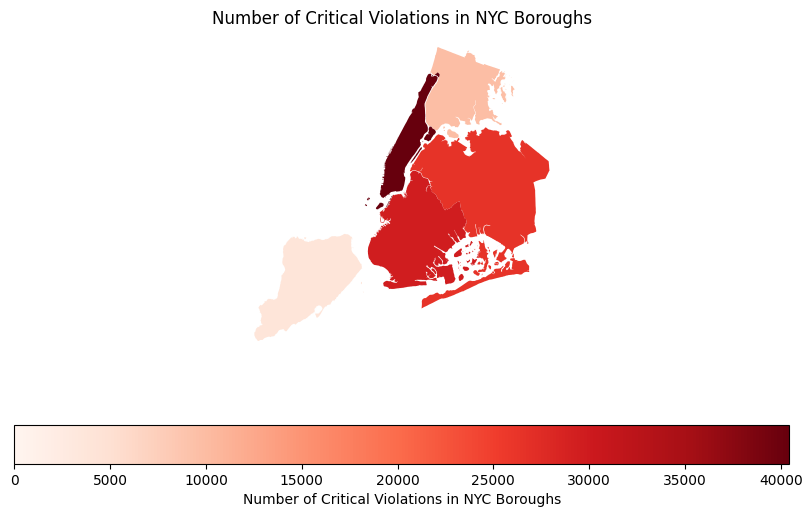

In [46]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

df['is_critical'] = df['critical_flag'].apply(lambda x: 1 if x == 'Critical' else 0)

agg_df = df.groupby('boro')['is_critical'].sum().reset_index()

gdf = gpd.read_file('NYC_Borough_Boundaries.shp')

merged_df = gdf.set_index('boro_name').join(agg_df.set_index('boro'))

norm = mcolors.Normalize(vmin=agg_df['is_critical'].min(), vmax=agg_df['is_critical'].max())

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged.plot(column='is_critical', ax=ax, legend=True,
            cmap='Reds', norm=norm,
            legend_kwds={'label': "Number of Critical Violations in NYC Boroughs",
                         'orientation': "horizontal"})

ax.set_axis_off()

plt.title('Number of Critical Violations in NYC Boroughs')
plt.show()


# Plotting for analysis of result

### critical by inspection_month/year

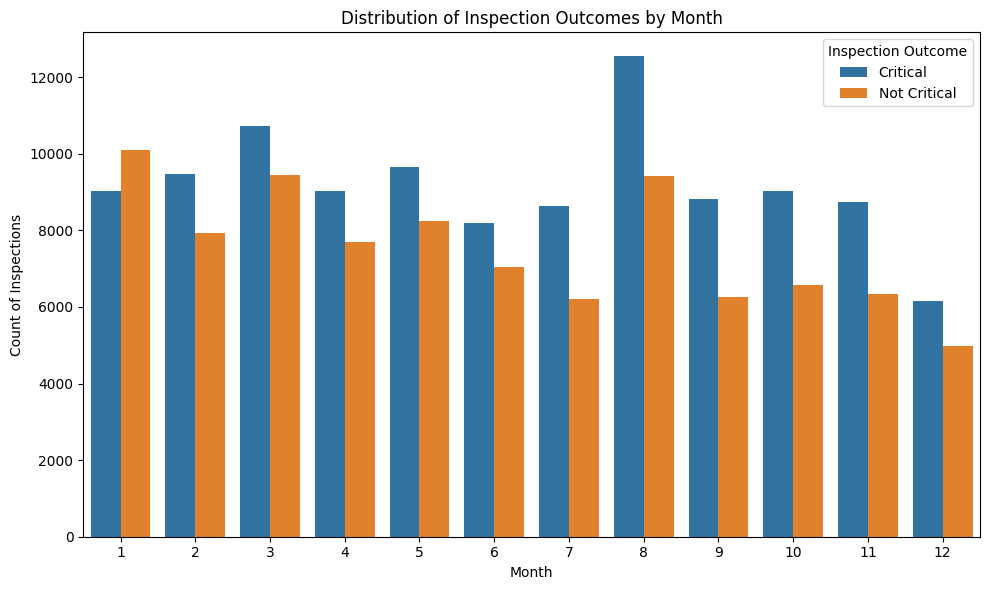

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='inspection_month', hue='critical_flag')
plt.title('Distribution of Inspection Outcomes by Month')
plt.xlabel('Month')
plt.ylabel('Count of Inspections')
plt.legend(title='Inspection Outcome')
plt.tight_layout()
plt.show()

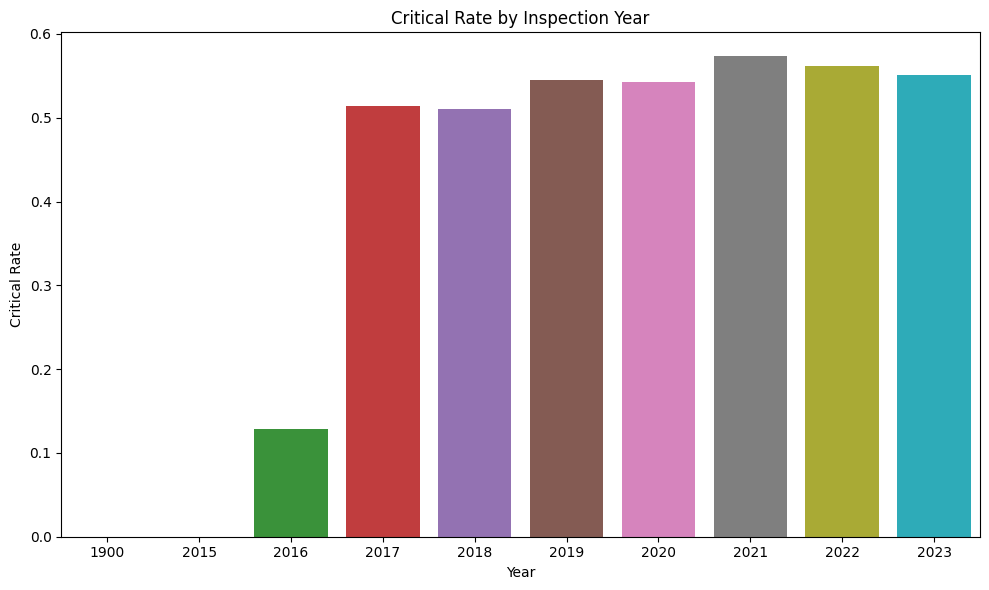

In [ ]:
df['is_critical'] = df['critical_flag'] == 'Critical'

critical_rate_by_year = df.groupby('inspection_year')['is_critical'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=critical_rate_by_year, x='inspection_year', y='is_critical')
plt.title('Critical Rate by Inspection Year')
plt.xlabel('Year')
plt.ylabel('Critical Rate')
plt.tight_layout()
plt.show()

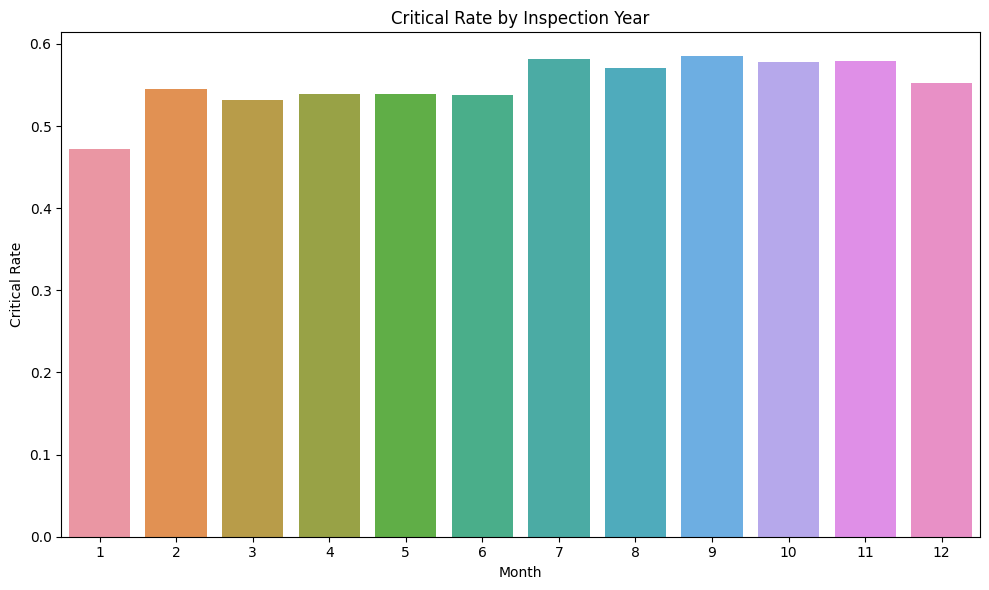

In [ ]:

critical_rate_by_year = df.groupby('inspection_month')['is_critical'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=critical_rate_by_year, x='inspection_month', y='is_critical')
plt.title('Critical Rate by Inspection Year')
plt.xlabel('Month')
plt.ylabel('Critical Rate')
plt.tight_layout()
plt.show()